In [2]:
from pyrep import PyRep
from pyrep.objects.shape import Shape
from pyrep.const import PrimitiveShape
from pyrep.errors import ConfigurationPathError
import time
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import tensorflow as tf
import keras
from keras.layers import Softmax,Input,TimeDistributed,Dense,Average,GlobalAveragePooling1D
from keras.layers import Concatenate,Lambda,RepeatVector,Conv2D,ConvLSTM2D,MaxPooling2D,BatchNormalization,Flatten,Reshape,UpSampling2D
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import random
import pylab as pl
from IPython import display
from IPython.core.display import HTML
from IPython.core.display import display as html_width
import tensorflow_probability as tfp
from tensorflow.keras.utils import Sequence
import matplotlib.image as mpimg

from keras.models import load_model
html_width(HTML("<style>.container { width:90% !important; }</style>"))

#### The LfD part of the code is taken from https://github.com/rssCNMP/CNMP

## Initializing scene

In [3]:
from pyrep.robots.arms.arm import Arm

class Trobot(Arm):

    def __init__(self, count: int = 0):
        super().__init__(count, 'Trobot', num_joints=3)

In [6]:

pr = PyRep()
# Launch the application with a scene file in headless mode
pr.launch('table.ttt', headless=False) 
pr.start()  # Start the simulation

# Do some stuff

In [7]:
pr.start()

In [86]:
#pr.shutdown()  # to shut down the scene

In [130]:
pr.stop()   # to initialize the scene

In [8]:
cnmp_traj=np.load('CNMP_pushing_solution.npy')

In [9]:
print(np.shape(cnmp_traj))

(300, 3)


In [10]:
Threedof_starting_position = [-0.50009131,  2.42891255, -0.91733952]

## Playing initial LfD solution 

In [11]:
agent_model = pr.import_model('Trobot3Dof.ttm')
agent=Trobot()
agent.set_joint_target_positions(Threedof_starting_position)
for i in range(50):
    pr.step()

In [12]:
cylinder_object_position = [0.281, -0.0613, 0.125]
end_goal_position = [-0.257, 0.238, 0.125]

In [13]:
target_object = Shape.create(type=PrimitiveShape.CYLINDER, 
                          color=[0,0,0], size=[0.05, 0.05, 0.05],
                          position=cylinder_object_position)

print(agent.get_joint_positions())
goal_pos = Shape.create(type=PrimitiveShape.CYLINDER, 
                      color=[1,0,0], size=[0.06, 0.06, 0.005],
                      position=end_goal_position,
                           static=True, respondable=False)
pr.step()

[-0.5120585560798645, 2.4381632804870605, -0.9081024527549744]


In [14]:
pr.step()

In [15]:
for i in range(300):
    agent.set_joint_target_positions(cnmp_traj[i])
    pr.step()
    pr.step()
    pr.step()
    pr.step()
    pr.step()
    pr.step()

In [16]:
target_object.remove()
goal_pos.remove()
agent_model.remove()
pr.step()

## Loading data for ACNMP

* <b>parameters</b>: Task_parameters corresponding to goal positions.
* <b>reward_true</b>: Recorded object trajectories during demonstrations

* <b>y</b>: Joint trajectories for 10 skill

* The last skill will be predicted in the code, for interpolation, places of skills should be swapped by uncommenting.


(10, 300, 3)
(10, 300, 3)
(10, 3)
(10, 3)


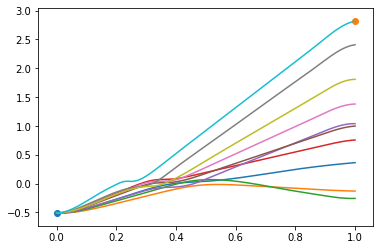

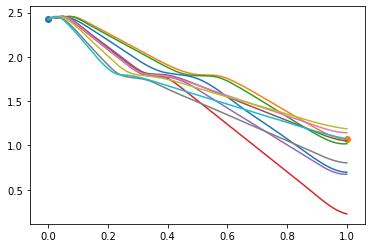

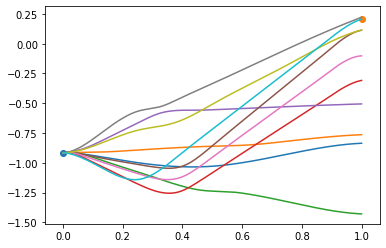

In [17]:
time_N = 300
times = np.linspace(0.,1.,time_N)
len_files=10
class Demonstration:
    def __init__(self):
        self.target_position= []
        self.object_position= []
        self.obj_trajectory = []
        self.joint_trajectory = []
A=Demonstration()
A.joint_trajectory=np.load('Threedofpushing_joint_trajectories.npy')
A.obj_trajectory = np.load('Threedofpushing_obj_trajectories.npy')
A.object_position = np.load ('Threedofpushing_object_position.npy')
A.target_position = np.load('Threedofpushing_target_position.npy')

print(np.shape(A.joint_trajectory))
print(np.shape(A.obj_trajectory))
print(np.shape(A.object_position))
print(np.shape(A.target_position))

parameters=np.zeros((10,2))
parameters[:,0] = A.target_position[:,0]
parameters[:,1] = A.target_position[:,1]

reward_true = np.zeros((10,300,2))

reward_true[:,:,0] = A.obj_trajectory[:,:,0]
reward_true[:,:,1] = A.obj_trajectory[:,:,1]

max_par=parameters.max()
min_par=parameters.min()
parameters=(parameters-min_par)/(max_par-min_par)+0.01

y = np.zeros((len_files,time_N,3))

y = A.joint_trajectory

# Uncomment the following for interpolation example

#ch_num = 7

#y[[ch_num,9]] = y[[9,ch_num]]
#parameters[[ch_num,9]] = parameters[[9,ch_num]]
#reward_true[[ch_num,9]] = reward_true[[9,ch_num]]


for xyz in range(3):
    for i in range(len_files):
        plt.plot(times,y[i,:,xyz])
    plt.scatter(times[0],y[9,0,xyz])
    plt.scatter(times[time_N-1],y[9,time_N-1,xyz])
    plt.show()


## Loading model inputs

* <b>n_max</b>: Hyperparameter that decides to the maximum number of observations CNMP uses. In this experiment, it is set to 5.
* <b>n</b>: Number of observations taken for one time step.

* <b>p</b>: Number that specifies the taken expert demonstration.

* <b>observation</b>: The input vector for CNMP network, which consists of n observations.

* <b>target</b>: A random time point concatenated with task parameters used for the training

* <b>Y</b>: The matrix that contains expert demonstrations.


In [18]:
n_max = 5
def get_train_sample():
    observation = np.zeros((1,n_max,6))
    observation_flag = np.zeros((1,1,n_max))
    target = np.zeros((1,1,3))
    p = random.randint(0, 8)
    n = random.randint(1,n_max)
    perm = np.random.permutation(time_N)
    
    for i in range(n):
        observation[0,i] = [times[perm[i]],parameters[p,0],parameters[p,1],y[p,perm[i],0],y[p,perm[i],1],y[p,perm[i],2]]
        observation_flag[0,0,i] = 1./n
    target[0,0,0] = times[perm[n]]
    target[0,0,1] = parameters[p,0]
    target[0,0,2] = parameters[p,1]
    return [observation,observation_flag,target], [[[y[p,perm[n],0],y[p,perm[n],1],y[p,perm[n],2],0.,0.,0.]]],p

### custom_loss2():
* The policy gradient loss where a Gaussian distribution is used for action values .

In [19]:
import keras.backend as K
def custom_loss2(taken, predicted):
    predicted_action_mean, predicted_action_sigma = tf.split(predicted, 2, axis=-1)
    taken_action, q_value =tf.split(taken,2,axis=-1)

    square_loss=tf.math.square(taken_action-predicted_action_mean)
    loss=(1./4.)*tf.math.multiply(square_loss,q_value)
    
    return K.mean(loss)

## The reinforcement learning model:

* Same as LfD network


In [20]:
observation_layer = Input(shape=(n_max,6))
observation_flag_layer=Input(shape=(1,n_max)) 

observation_encoded = TimeDistributed(Dense(128, activation='relu'))(observation_layer)
observation_encoded = TimeDistributed(Dense(128, activation='relu'))(observation_encoded)
observation_encoded = TimeDistributed(Dense(64, activation='relu'))(observation_encoded)
observation_encoded = TimeDistributed(Dense(32))(observation_encoded)

matmul_layer=Lambda(lambda x:(tf.matmul(x[0],x[1])), output_shape =(1,32))

representation=matmul_layer([observation_flag_layer,observation_encoded])

target_layer = Input(shape=(1,3))

decoder_input = Concatenate(axis=-1)([representation, target_layer])

decoder = Dense(128, activation='relu')(decoder_input)
decoder = Dense(128, activation='relu')(decoder)
decoder = Dense(128, activation='relu')(decoder)

output_layer = Dense(6)(decoder)

#next_model_input=Concatenate(axis=2)([decoder_input, output_layer])
rl_input=decoder_input

model2 = Model(inputs=[observation_layer,observation_flag_layer,target_layer],outputs=output_layer)
model2.compile(optimizer = Adam(lr = 5e-5),loss=custom_loss2)
model2.summary()

representation_model2 = Model(inputs=[observation_layer,observation_flag_layer,target_layer],outputs=rl_input)





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5, 6)         0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 5, 128)       896         input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 5, 128)       16512       time_distributed_1[0][0]         
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 5, 64)        8256        time_distributed_2[0][0]         
________________________________________________________________________________________

#### The weights of LfD network are copied to bootstrap reinforcement learning agent

In [21]:
model2.load_weights('naive_cnmp_3dof_pushing.h5')

#Uncomment this for interpolation case
#model2.load_weights('naive_cnmp_3dof_pushing_7.h5')

### Mismatch function to measure the differences of old and new policy

In [22]:
def mismatch_func(actions1,actions2):
    error=0
    for i in range(time_N):
        error2=np.square(actions1[i]-actions2[i])
        error=max(error,error2)
    return error

#### Gaussian Pdf

In [23]:
def normpdf(x, mean, sd):
    denom = sd*(2*math.pi)**0.5
    num= math.exp(-0.5*((x-mean)/float(sd))**2)
    return num/denom

### The states are recorded by only using the start point and task parameters as observation. 

In [24]:
pred_y = np.zeros(time_N)
pred_std = np.zeros(time_N)
states1=[]
states2=[]
states3=[]
observation = np.zeros((1,n_max,6))
observation_flag = np.zeros((1,1,n_max))
target = np.zeros((1,1,3))
observation[0,0] = [times[0],parameters[9,0], parameters[9,1], -0.51061333,  2.42277872, -0.914231]

observation_flag[0,0,0] = 1.

for i in range(time_N):
    
    target[0,0,0] = times[i]
    target[0,0,1] = parameters[9,0]
    target[0,0,2] = parameters[9,1]
    if(i==0):
        states1=observation
        states2=observation_flag
        states3=target
    else:
        states1=np.concatenate((states1,observation),axis=0)
        states2=np.concatenate((states2,observation_flag),axis=0)
        states3=np.concatenate((states3,target),axis=0)
states=[states1,states2,states3]

In [25]:
def square_error(arr1,arr2):
    errsum=0
    for j in range(2):
        errsum+=np.square(arr1[j]-arr2[j])
    return errsum

In [26]:
max_reward = 5
var = 0.05
reward_array = []

In [27]:
saved_trajectory = np.zeros((300,3))

In [28]:
def rl_agent(c_t,c): 
    global max_reward
    global var
    global saved_trajectory
    for i in range(100):                    #supervised_learning
        inp,out,sample = get_train_sample()
        out[0][0][3]=1
        out[0][0][4]=1
        out[0][0][5]=1

        data = model2.fit(inp,out,batch_size=1,verbose=0)
        
    
    actions, rewards, rewards2 = [], [], []        #arrays to record 
    action_prob=[]
    actions_mean=[]
    
    agent_model = pr.import_model('Trobot.ttm')    #for each step robot and objects are recreated.
    agent=Trobot()
    pr.step()
    agent.set_joint_target_positions(Threedof_starting_position)
    for i in range(50):
        pr.step()
    
    cylinder_object_position = A.object_position[9]
    end_goal_position = A.target_position[9]
    
    #cylinder_object_position = A.object_position[7]           #uncomment for interpolation
    #end_goal_position = A.target_position[7]
    
    target_object = Shape.create(type=PrimitiveShape.CYLINDER, 
                          color=[0,0,0], size=[0.05, 0.05, 0.05],
                          position=cylinder_object_position)

    
    goal_pos = Shape.create(type=PrimitiveShape.CYLINDER, 
                          color=[1,0,0], size=[0.06, 0.06, 0.005],
                          position=end_goal_position,
                               static=True, respondable=False)
    pr.step()
    
    #Rewards for mean of the policy ditribution are observed
    traj_list = []
    for i in range(time_N):
        
        pred= model2.predict([[states1[i]],[states2[i]],[states3[i]]])[0][0]

        reward2= 0
        
        agent.set_joint_positions(pred[:3])
        traj_list.append(pred[:3])
        obj=target_object.get_position()

        reward2=-square_error(reward_true[9,i] ,obj)

        
        reward2=reward2/1.
        rewards2.append(reward2)
        
    observed_reward=np.absolute(np.sum(rewards2))
    reward_array.append(observed_reward)
    var = min(observed_reward/10,0.05)
    if observed_reward<max_reward:
        max_reward = observed_reward
        saved_trajectory = np.asarray(traj_list)
        print("new_best")
        
    target_object.remove()
    agent_model.remove()
    goal_pos.remove()
    pr.step()
    
    agent_model = pr.import_model('Trobot.ttm')           #  robot and objects are recreated.
    agent=Trobot()
    pr.step()
    
    agent.set_joint_target_positions(Threedof_starting_position)
    for i in range(50):
        pr.step()
        
    starting_joints=agent.get_joint_positions()    
    cylinder_object_position = A.object_position[9]
    end_goal_position = A.target_position[9]
    
    #cylinder_object_position = A.object_position[7]           #uncomment for interpolation
    #end_goal_position = A.target_position[7]
    
    target_object = Shape.create(type=PrimitiveShape.CYLINDER, 
                          color=[0,0,0], size=[0.05, 0.05, 0.05],
                          position=cylinder_object_position)

    
    goal_pos = Shape.create(type=PrimitiveShape.CYLINDER, 
                          color=[1,0,0], size=[0.06, 0.06, 0.005],
                          position=end_goal_position,
                               static=True, respondable=False)
    pr.step()
    
    
    samples2=[]
    
    #smoothed gaussian noise is added on top of policy mean.

    for i in range (3):

        mean = 0
        std = var 
        num_samples = 20
        samples = np.random.normal(mean, std, size=num_samples)

        old_indices = np.arange(0,len(samples))
        new_length = 300
        new_indices = np.linspace(0,len(samples)-1,new_length)

        spl = UnivariateSpline(old_indices,samples,k=3,s=0.1)

        samples2.append(spl(new_indices))
        
    # rewards for sampled policy are obtained
    
    for i in range(time_N):
        
        pred= model2.predict([[states1[i]],[states2[i]],[states3[i]]])[0][0]
        selected_action=[pred[0]+samples2[0][i],pred[1]+samples2[1][i],pred[2]+samples2[2][i]]
        #selected_action = [np.random.normal(pred[0], 0.1, 1)[0], np.random.normal(pred[1], 0.1, 1)[0], np.random.normal(pred[2], 0.1, 1)[0]]
        action_prob.append([normpdf(selected_action[0], pred[0], var),normpdf(selected_action[1], pred[1], var),normpdf(selected_action[2], pred[2], var)])
        actions.append(selected_action)
        actions_mean.append(pred[:3])

    object_trajectory = []
    for i in range(time_N):
        reward = 0
        
        agent.set_joint_positions(actions[i])
        
        obj=target_object.get_position()
        object_trajectory.append(obj)
        
    
        reward=-square_error(reward_true[9,i] ,obj)
        reward=reward*1.0
        
        rewards.append(reward)
    object_trajectory = np.asarray(object_trajectory)

    
    target_object.remove()
    agent_model.remove()
    goal_pos.remove()
    pr.step()
    
    
    gradient_rewards = np.zeros((time_N))

    for i in range(time_N):
        gradient_rewards[i]=rewards[i]-rewards2[i]

    gradient_rewards /= np.std(gradient_rewards)

    advantages=np.zeros((time_N,1,6))
    
    for i in range(time_N):
        for j in range(3):
            advantages[i][0][j]=actions[i][j]
            advantages[i][0][j+3]=gradient_rewards[i]
       

    data = model2.fit(states,advantages,verbose=0)

    counter=0
    while(var>0.1):                                           # off-policy learning
        counter=counter+1
        actions2=[]
        action_prob2=[]
        for i in range(50):                                    #supervised learning
            inp,out,sample = get_train_sample()
            out[0][0][3]=1
            out[0][0][4]=1
            out[0][0][5]=1
            
            data = model2.fit(inp,out,batch_size=1,verbose=0)
            
        for i in range(time_N):                             #reinforcement learning
            
            pred= model2.predict([[states1[i]],[states2[i]],[states3[i]]])[0][0]
            selected_action = actions[i]
            selected_action2 = [np.random.normal(pred[0], var, 1)[0], np.random.normal(pred[1], var, 1)[0], np.random.normal(pred[2], var, 1)[0]]
            action_prob2.append([normpdf(selected_action[0], pred[0], var),normpdf(selected_action[1], pred[1], var),normpdf(selected_action[2], pred[2], var)])
            actions2.append(pred[:3])
        advantages2=np.zeros((time_N,1,6))    
        for i in range(time_N):
            for j in range(3):
                advantages2[i][0][j]=actions[i][j]
                advantages2[i][0][3+j]=gradient_rewards[i]*min(1,(action_prob2[i][j]/action_prob[i][j]))
        #data = model2.fit(states,advantages2,verbose=0)
        act1=np.transpose(actions_mean)
        act2=np.transpose(actions2)
        
        plcy_diff1=mismatch_func(act1[0],act2[0])
        plcy_diff2=mismatch_func(act1[1],act2[1])
        plcy_diff3=mismatch_func(act1[2],act2[2])
        
        plcy_diff=max(plcy_diff1,plcy_diff2,plcy_diff3)
        if plcy_diff>0.001:
            break
        elif counter>50:             #check for infinite loop
            break
        else:
            print("offpolicy")
            data = model2.fit(states,advantages2,verbose=0)
        #print(KL_diff)
    return observed_reward

In [29]:
pr.start()

In [30]:
#target_object.remove()
#agent_model.remove()
#goal_pos.remove()
pr.step()

In [31]:
training_loss = np.zeros(2000)
reward_array_list = []
reward_array_list.append(reward_array)
for kk in range(10):
    model2.load_weights('naive_cnmp_3dof_pushing.h5')
    #Uncomment this for interpolation case
    #model2.load_weights('naive_cnmp_3dof_pushing_7.h5')
    reward_array = []
    for step in range(100):
        rrr=rl_agent([times[0],times[299]],[y[9,0],y[9,299]])
        
        print(step)
    reward_array_list.append(reward_array)

new_best
0
new_best
1


KeyboardInterrupt: 

In [112]:
saved_trajectory

array([[-4.69793379e-01,  2.36968136e+00, -8.53807569e-01],
       [-4.69793379e-01,  2.36968136e+00, -8.53807569e-01],
       [-4.68066633e-01,  2.36962366e+00, -8.49924564e-01],
       [-4.64178830e-01,  2.36734390e+00, -8.45393538e-01],
       [-4.58886921e-01,  2.36435866e+00, -8.39875340e-01],
       [-4.53598082e-01,  2.36140013e+00, -8.34372520e-01],
       [-4.48172361e-01,  2.35846710e+00, -8.28798413e-01],
       [-4.42686141e-01,  2.35413718e+00, -8.23413134e-01],
       [-4.37354386e-01,  2.34756947e+00, -8.17982435e-01],
       [-4.32117403e-01,  2.33879876e+00, -8.12129140e-01],
       [-4.26863879e-01,  2.33001995e+00, -8.06212664e-01],
       [-4.21592593e-01,  2.32109070e+00, -8.00170541e-01],
       [-4.16311681e-01,  2.31214523e+00, -7.94102550e-01],
       [-4.10816133e-01,  2.30286264e+00, -7.87847400e-01],
       [-4.05192286e-01,  2.29343224e+00, -7.81472683e-01],
       [-3.99555445e-01,  2.28397250e+00, -7.75092244e-01],
       [-3.92737210e-01,  2.27319241e+00

In [32]:
pr.stop()  # Stop the simulation


In [33]:
pr.start()

In [34]:
extra_reward = np.load('extrapolation_reward2.npy')
#extra_reward = reward_array_list #uncomment to use training result
for i in range(10):
    for j in range(100):
        extra_reward[i,j]=extra_reward[i,j]*(-1)
        
mean_extrapolation = np.mean(extra_reward,axis=0)
std_extrapolation = np.std(extra_reward,axis=0)

In [35]:
inter_reward = np.load('intrapolation_reward2.npy')
mean_interpolation = np.mean(inter_reward,axis=0)
std_interpolation = np.std(inter_reward,axis=0)


Text(0, 0.5, 'Reward (in m)')

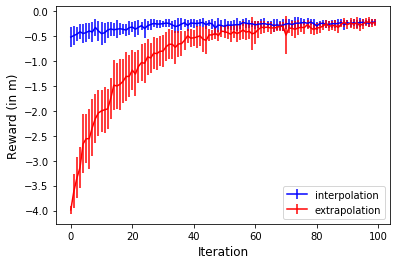

In [36]:

plt.errorbar(range(100), mean_interpolation, yerr=std_interpolation, color = 'b' , label = 'interpolation')
plt.errorbar(range(100), mean_extrapolation, yerr=std_extrapolation, color = 'r' , label = 'extrapolation')

plt.legend()
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Reward (in m)', fontsize=12)

In [237]:
pr.shutdown()   # Close the application